# AIR POLLUTION AND HOW COVID WAS GOOD FOR OUR LUNGS

In [7]:
#Import necessary libraries

import os
import re
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from datetime import datetime

### Table of Contents

* [Objective/Business Understanding](#objective)
* [Data Gathering and understanding](#data_gather)
* [Data Preparation](#data_prep)
    * [Data Cleaning](#data_cleaning)
    * [Join with external "Country name" dataset](#join)
* [Evaluation](#evaluation)
    * [How much the air quality varied during the year 2020 relative to 2019 in Spain? Which pollutant underwent the largest variation?](#first_question)
    * [How was the monthly evolution across the whole year of 2020](#second_question)
    * [How did the air quality changed in the Spanish cities?](#third_question)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)

# Objective/Business understanding <a class='anchor' id='objective'>

Air pollution is one the main risk factors to develop diseases. The Covid pandemic has given us with an extraordinary situation to study how fast and how much the air pollution would decrease given a set of health security measures. This data can be useful and provides us some understanding for future specific measures to decrease the air pollution in the cities. Has Covid benefitted us in this regard? For this we will be analyzing Spain, as it was one of the most strict countries in terms of health security measures that spanned throughout the whole year of 2020 with a full (and mandatory) confinement of 3 months from March 15th to June 21st.

We will be answering three different questions:

1. Evaluate how much the air quality varied during the year 2020 relative to 2019 in Spain and which pollutant underwent the largest variation
2. How was the monthly evolution of air pollution across the whole year of 2020
3. What cities showed the largest pollution decrease in 2020
    


# Data Gathering and understanding <a class='anchor' id='data_gather'>

To be able to answer the previous questions we will need air quality data from the main city centers in Spain. The time resolution for this measurements needs to be either hourly or daily. Since we will be looking, at most, at a monthly temporal resolution, daily data is suitable for this study. 

The data will be extracted from the www.aqi.cn webpage, specifically from: https://aqicn.org/data-platform/covid19/report where they provide a curated dataset with daily data across 94 countries and more than 600 cities. It can be downloaded manually from the previous link or with the use of the get_aqi_data() function below:

In [8]:
def get_aqi_data():
    
    '''Gets all the daily AQI data from https://aqicn.org/data-platform/covid19/report from 2019 to 2020.
    INPUT: None
    OUTPUT: A dictionary with all the dataframes where key:value pairs correspond to year:dataframe. It also creates csv files for all of them in
    the current folder'''

    
    strs = 'https://aqicn.org/data-platform/covid19/report/22408-10ad85dd/'
    CSV_URLS = 'https://aqicn.org/data-platform/covid19/report/22408-10ad85dd/'
    
    #Uncomment the following line to download data from 2015 to 2020
    #time_periods = ['2020Q1', '2020Q2', '2020Q3', '2020Q4', '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2018H1', '2017H1', '2016H1', '2015H1'] 
    
    time_periods = ['2020Q1', '2020Q2', '2020Q3', '2020Q4', '2019Q1', '2019Q2', '2019Q3', '2019Q4']

    dic = {}
    for period in time_periods:
        print(period)
    
        response = requests.get(CSV_URLS + period)
        string_data = response.content.decode('utf-8')
        list_data = [row.split(',') for row in string_data.split('\n')]
        # Remove header
        del list_data[:4]
    
        columns = list_data[0]
        values = list_data[1:]
    
        dic[period] = pd.DataFrame(values, columns=columns)
        
    for name, df in dic.items():
        df.to_csv('./'+name+'.csv')
    
    return dic



In [9]:
dct = get_aqi_data()

#Save data to csv files
for name, df in dct.items():
    df.to_csv('./'+name+'.csv')

2020Q1
2020Q2
2020Q3
2020Q4
2019Q1
2019Q2
2019Q3
2019Q4


# Data Preparation <a class='anchor' id='data_prep'>

## File grouping and concatenation of DataFrames <a class='anchor' id='concatenation'>

As we can see, the data for 2019 and 2020 is split into 4 different for each year when downloaded from the source. Ideally, we want all the data in a single dataframe for further processing: 

In [10]:
def concatenate_per_year(year):
    '''Helper function: Puts together the csv files for a single year in one DataFrame
    INPUT: int year to group
    OUTPUT: pd.DataFrame'''
    files_in_folder = [file for file in os.listdir() if os.path.isfile(os.path.join(os.getcwd(),file))]
                                  
    df = pd.DataFrame()
    for file in files_in_folder:
        if re.search('^{}'.format(str(year)), string=file):
            temp_df = pd.read_csv(file)
            df = pd.concat([df, temp_df])
    return df

def concatenate_all_years(years):
    '''Creates a single dataframe with the data across all years contained in years
    INPUT: list of ints years to concatenate
    OUTPUT: pd.DataFrame with the data for all years'''
    df = pd.DataFrame()
    for year in years:
            df = pd.concat([df, concatenate_per_year(year)])
    return df
        
            

In [11]:
# Put all the downloaded data together in a single dataframe "df"
df = concatenate_all_years([2019,2020])
# Drop useless columns from the concatenation process
df = df.reset_index().drop(['index', 'Unnamed: 0'], axis=1)
df.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,2019-01-16,AE,Abu Dhabi,pm10,24.0,86.0,99.0,97.0,179.40
1,2019-01-22,AE,Abu Dhabi,pm10,24.0,51.0,57.0,55.0,23.75
2,2019-01-26,AE,Abu Dhabi,pm10,24.0,136.0,173.0,160.0,941.96
3,2019-01-07,AE,Abu Dhabi,pm10,24.0,60.0,91.0,72.0,1006.88
4,2019-01-10,AE,Abu Dhabi,pm10,24.0,82.0,93.0,87.0,57.97


In [12]:
print('Number of cities in the dataset: {} | Number of countries in the dataset: {}'.format(df.City.unique().size, df.Country.unique().size))

Number of cities in the dataset: 617 | Number of countries in the dataset: 96


In [13]:
df.shape

(4502035, 9)

## Data Cleaning <a class='anchor' id='data_cleaning'>

Note that in this dataset the value reported for the air quality is the sample median. This magnitude is statistically sound to report air pollution in a particula **day** as it can vary very rapidly along the day and whose distribution might be highly skewed. We will not be using the "variance" in the dataset, because it is defined as the variance of the raw data (https://aqicn.org/data-platform/covid19/), rather than the variance of the distribution of the median (which will be the quantity we will use). Note that the raw data is not provided, only the calculated median. For statistical analysis we will be using the natural spread of data. 

In [14]:
df.drop(['variance', 'min', 'max'], axis=1, inplace=True)

Moreover, as we can see in the following cell, in the "Specie" column we not only have the AQI for pollutant species, but also other magnitudes like weather properties during the day. These parameters will not be used in this study as we will focus solely on relative changes of the air pollution levels between 2019 and 2020. 

In [15]:
df.Specie.unique()

array(['pm10', 'humidity', 'o3', 'so2', 'wind-speed', 'wind-gust', 'dew',
       'pm25', 'no2', 'pressure', 'temperature', 'precipitation', 'co',
       'wd', 'uvi', 'aqi', 'pm1', 'mepaqi', 'pol', nan, 'wind speed',
       'wind gust', 'neph'], dtype=object)

We will study nitrogen dioxide (NO$_2$), which is the main byproduct of vehicle traffic, together with sulfur dioxide (SO$_2$), air particle of less than 10 microns (PM$_{10}$) and less than 2.5 microns (PM$_{25}$) which are also main pollutants coming from oil combustion i.e industries and vehicles.

Thus, let's filter those pollutant species from our dataframe:

In [16]:
pollutants = ['pm10', 'so2', 'no2', 'pm25']
df_whole = df.copy(deep=True)
df = df[df.Specie.isin(pollutants)]

In [17]:
df.Specie.unique(), df.shape

(array(['pm10', 'so2', 'pm25', 'no2'], dtype=object), (1426275, 6))

Now we have all data (almost 1.5 million points) from 2019-2020 in one DataFrame corresponding to the different air pollutants.

Do we have missing values?:

In [18]:
df.isna().sum()

Date       0
Country    0
City       0
Specie     0
count      0
median     0
dtype: int64

Let's check now what datatypes we have in our table:

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1426275 entries, 0 to 4501349
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   Date     1426275 non-null  object 
 1   Country  1426275 non-null  object 
 2   City     1426275 non-null  object 
 3   Specie   1426275 non-null  object 
 4   count    1426275 non-null  float64
 5   median   1426275 non-null  float64
dtypes: float64(2), object(4)
memory usage: 76.2+ MB


Everything looks good except the date, which we want to parse to obtain a datetime object

In [20]:
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1426275 entries, 0 to 4501349
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype         
---  ------   --------------    -----         
 0   Date     1426275 non-null  datetime64[ns]
 1   Country  1426275 non-null  object        
 2   City     1426275 non-null  object        
 3   Specie   1426275 non-null  object        
 4   count    1426275 non-null  float64       
 5   median   1426275 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 76.2+ MB


In [22]:
np.sort(df.Date.dt.year.unique())

array([2018, 2019, 2020, 2021], dtype=int64)

We have data from 2018 and 2021 even though we only downloaded the 2019-2020 time-span

In [23]:
print('Date of data from 2018: {}. Date of data from 2021: {}'.format(df[df.Date.dt.year == 2018].Date.unique(), df[df.Date.dt.year == 2021].Date.unique()))

Date of data from 2018: ['2018-12-31T00:00:00.000000000']. Date of data from 2021: ['2021-01-02T00:00:00.000000000' '2021-01-01T00:00:00.000000000'
 '2021-01-03T00:00:00.000000000']


But we only have data for December 31$^{st}$ for 2018 and the first 3 days of January, 2021. Since these values won't give us any relevant information for our study let's drop those rows:

In [24]:
df = df[(df.Date.dt.year > 2018) & (df.Date.dt.year < 2021)]

## Join with external "Country name" dataset <a class='anchor' id='join'>

Although in this work we will only analyze Spain, for further work it may be useful to include all country names in the dataset apart from their 2-letter code. Although useful for simplicity, the latter renders the data a bit cryptic. The country name dataset was extracted from datahub.io in the following link: https://datahub.io/core/country-list

In [25]:
# Read the data from the csv file
country_name = pd.read_csv('.\country_codes.txt')
country_name

,Name,Code
0,Afghanistan,AF
1,Ã…land Islands,AX
2,Albania,AL
3,Algeria,DZ
4,American Samoa,AS
...,...,...
244,Wallis and Futuna,WF
245,Western Sahara,EH
246,Yemen,YE
247,Zambia,ZM


In [26]:
country_name.dtypes

Name    object
Code    object
dtype: object

Are there any missing values in this dataset?

In [27]:
country_name.isna().sum()

Name    0
Code    1
dtype: int64

There is a missing value in the country_name dataframe in the "Code" column. What country is it?

In [28]:
country_name.loc[country_name[country_name.Code.isna()].index[0], :]

Name    Namibia
Code        NaN
Name: 153, dtype: object

Is it in our df dataframe? The 2-letter code for Namibia is 'NA'

In [29]:
df[df.Country == 'NA'].shape

(0, 6)

Since this country is not in our air pollution dataset then we will not need it and we can safely remove it from country_name:

In [30]:
country_name.dropna(inplace=True)
country_name.shape

(248, 2)

Now we need to check that every country code in our air pollution dataset is present in the country_name dataframe. 

In [31]:
def check_contents(arr1, arr2):
    '''Checks if all elements in arr1 are contained in arr2
    INPUT: arr1, arr2 arrays with the elements to compare
    OUTPUT: boolean array with the length of arr1. If True then the element in arr1 is in arr2. If False, it is not present'''
    
    bool_arr = np.array([])
    for country in arr1:
        boolean = country in arr2
        bool_arr = np.append(bool_arr, boolean)

    if bool_arr.all():
        print('All elements in array 1 are in array 2')
    else: 
        missing = len(bool_arr) - bool_arr.sum()
        print('There are {} elements of array 1 missing in array 2'.format(int(missing)))
        
    return bool_arr
    

In [32]:
air_pollution_countries = df.Country.unique()
country_name_countries = country_name.Code.unique()

bool_arr_1 = check_contents(air_pollution_countries, country_name_countries)

There are 1 elements of array 1 missing in array 2


Which one is not present in country_names?

In [33]:
df.Country.unique()[bool_arr_1 == False]

array(['XK'], dtype=object)

'XK' corresponds to Kosovo. As this country is not contained in the country_name dataset, let's include it manually.

In [34]:
kosovo_df = pd.DataFrame([['Kosovo', 'XK']], columns=country_name.columns)
country_name = pd.concat([country_name, kosovo_df], axis=0).reset_index(drop=True)
country_name

,Name,Code
0,Afghanistan,AF
1,Ã…land Islands,AX
2,Albania,AL
3,Algeria,DZ
4,American Samoa,AS
...,...,...
244,Western Sahara,EH
245,Yemen,YE
246,Zambia,ZM
247,Zimbabwe,ZW


Now rechecking that everything is correct:

In [35]:
air_pollution_countries = df.Country.unique()
country_name_countries = country_name.Code.unique()

bool_arr_1 = check_contents(air_pollution_countries, country_name_countries)

All elements in array 1 are in array 2


Every country code in country_name is in our df dataframe. We can now do an inner join of both tables on the country code and do some renaming and re-arranging of columns:


In [36]:
df = pd.merge(df, country_name, how='inner', left_on='Country', right_on='Code').drop('Code', axis=1).rename(columns={'Name':'Country_name', 'Specie':'Pollutant'})
df = df[['Date', 'Country', 'Country_name', 'City', 'Pollutant', 'count', 'median']]
df.head()

,Date,Country,Country_name,City,Pollutant,count,median
0,2019-01-16,AE,United Arab Emirates,Abu Dhabi,pm10,24.0,97.0
1,2019-01-22,AE,United Arab Emirates,Abu Dhabi,pm10,24.0,55.0
2,2019-01-26,AE,United Arab Emirates,Abu Dhabi,pm10,24.0,160.0
3,2019-01-07,AE,United Arab Emirates,Abu Dhabi,pm10,24.0,72.0
4,2019-01-10,AE,United Arab Emirates,Abu Dhabi,pm10,24.0,87.0


Now that we have the dataset for different countries, let's narrow it down to the country of this study: Spain. As we will need it later, let's include the city population of the spanish cities present in our air pollution dataset:

In [37]:
df_spain = df[df.Country =='ES']

In [38]:
print('Number of datapoints: {}. Number of spanish cities: {}'.format(df_spain.shape[0], df_spain.City.unique().size))

Number of datapoints: 59549. Number of spanish cities: 23


In [39]:
df_spain.head()

,Date,Country,Country_name,City,Pollutant,count,median
663836,2019-01-03,ES,Spain,Las Palmas de Gran Canaria,pm25,206.0,25.0
663837,2019-01-06,ES,Spain,Las Palmas de Gran Canaria,pm25,216.0,34.0
663838,2019-01-07,ES,Spain,Las Palmas de Gran Canaria,pm25,195.0,25.0
663839,2019-01-18,ES,Spain,Las Palmas de Gran Canaria,pm25,178.0,21.0
663840,2019-01-19,ES,Spain,Las Palmas de Gran Canaria,pm25,177.0,17.0


# Evaluation <a class='anchor' id='evaluation'>

## How much the air quality varied during the year 2020 relative to 2019 in Spain? Which pollutant underwent the largest variation? <a class='anchor' id='first_question'>

As specified in the ReadMe file the averaging process follows a bottom-up approach where the country average will be done by first doing the averages of all cities in the country separately and then using those values to calculate the whole country average. Moreover, the time-related averages will be done in the same way, by doing the monthly average as the average of all days for each month and the average of all months to calculate the yearly average. This implies that we are giving every city the same weight and importance both spatially and temporally in the calculations. Any weighing factors may be included in the future for other purposes/studies, such us city/country population, area or population density, among others.

Therefore, in order to make the country calculation we need several functions, namely: (i) one that calculates the monthly average in each city (monthly_city_pollutant()) and (ii) one that calculates the yearly average in each city (yearly_city_pollutant()). With those 2 functions we can then calculate (iii) the monthly average in each country (monthly_country_pollutant()) and finally (iv) the yearly average of the country (yearly_country_pollutant()):

In [40]:
df_spain.head()

,Date,Country,Country_name,City,Pollutant,count,median
663836,2019-01-03,ES,Spain,Las Palmas de Gran Canaria,pm25,206.0,25.0
663837,2019-01-06,ES,Spain,Las Palmas de Gran Canaria,pm25,216.0,34.0
663838,2019-01-07,ES,Spain,Las Palmas de Gran Canaria,pm25,195.0,25.0
663839,2019-01-18,ES,Spain,Las Palmas de Gran Canaria,pm25,178.0,21.0
663840,2019-01-19,ES,Spain,Las Palmas de Gran Canaria,pm25,177.0,17.0


In [41]:
def monthly_city_pollutant(df):
    ''' For every pollutant and city this function calculates the monthly average
    
    INPUT: dataframe with pollution data with the form of the "df" or "df_spain" dataframe
    OUTPUT: dataframe with the monthly average of pollutants for every city in the input data'''
    
    print('Implementing function: monthly_city_pollutant. This may take a while.')
    final_df = pd.DataFrame()
   
    pollutants = df.Pollutant.unique()
    for pollutant in pollutants:
        pollutant_df = df[df.Pollutant == pollutant]
        countries = pollutant_df.Country.unique()
        for country in countries:
            country_df = pollutant_df[pollutant_df.Country == country]
            cities_country = country_df.City.unique()
            for city in cities_country:
                city_df = country_df[country_df.City == city]
                years = city_df.Date.dt.year.unique()
                for year in years:
                    year_df = city_df[city_df.Date.dt.year == year]
                    months = year_df.Date.dt.month.unique()
                    for month in months:
                        #Dataframe with a particular city in a given country
                        month_df = year_df[year_df.Date.dt.month == month]
                            
                        mean_ser = month_df['median']
                        date_string = '{}/{}'.format(year, month)
                                               
                        #Standard deviation of the month distribution
                        std_dev = np.std(month_df['median'])
                        no_points = month_df.count()[0]
                         
                        #Standard deviation of the mean
                        std_dev_mean = std_dev/np.sqrt(month_df.count()[0])
                            
                        ## t-sutdent confidence interval
                        alpha= 0.95
                        error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
                        
                        
                        #Create a temporary dataframe 
                        temp_df = pd.DataFrame(data={'Date':datetime.strptime(date_string, '%Y/%m'), 'Month': month, 'Country': country, 'Country_name': month_df.Country_name.unique()[0], \
                                                     'City': city, 'Pollutant': pollutant, 'No_points': no_points, \
                                                     'AQI': [mean_ser.mean()], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
                        
                        #Concatenate temporary dataframe with final_df (initially empty)
                        final_df = pd.concat([final_df, temp_df])
                        
                        
                           
    return final_df.reset_index().drop('index', axis=1)
    

In [42]:
def yearly_city_pollutant(df):
    '''Calculates the yearly average of pollutants in every city of the input data
    
    INPUT: df: pd.DataFrame with pollution data with the form of df dataframe
    OUTPUT: dataframe with the monthly average of pollutants for every city in the input data'''
    
    if ('AQI' not in df.columns) and ('Month' not in df.columns):
        inp = input('''Beware: inserting the original DataFrame will imply a long runtime process (> 10 min). It is advised
                    to use the returned DataFrame after applying the monthly_city_pollutant() function. Do you want to continue anyway?\n
                    Type "y" for Yes\n
                    Type "n" for No\n''')
        
        if inp.lower() == 'y':
            df = monthly_city_pollutant(df)
            
        else:
            return
        
    elif ('AQI' in df.columns) and ('Month' not in df.columns):
        print('This function only accepts the original dataframe or the output from monthly_city_pollutant')
        return
    
    print('Implementing function: yearly_city_pollutant')
    final_df = pd.DataFrame()
   
    pollutants = df.Pollutant.unique()
    for pollutant in pollutants:
        pollutant_df = df[df.Pollutant == pollutant]
        countries = pollutant_df.Country.unique()
        for country in countries:
            country_df = pollutant_df[pollutant_df.Country == country]
            cities_country = country_df.City.unique()
            for city in cities_country:
                city_df = country_df[country_df.City == city]
                years = city_df.Date.dt.year.unique()
                for year in years:
                    year_df = city_df[city_df.Date.dt.year == year]
                            
                    mean_ser = year_df['AQI']
                    date_string = '{}'.format(year)
                            
                    #Standard deviation of the mean. Assuming i.i.d i.e Cov = 0
                    no_points = year_df.count()[0]
                    std_dev_mean = np.sqrt((year_df.std_dev ** 2).sum())/year_df.count()[0]
 

                    # t-sutdent confidence interval
                    alpha= 0.95
                    error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
                        
                                    
                    #Create a temporary dataframe         
                    temp_df = pd.DataFrame(data={'Date':datetime.strptime(date_string, '%Y'), 'Country': country, 'Country_name': year_df.Country_name.unique()[0], \
                                                 'City': city, 'Pollutant': pollutant, 'No_points': no_points, 'AQI': [mean_ser.mean()], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
                    
                    #Concatenate temporary dataframe with final_df (initially empty)
                    final_df = pd.concat([final_df, temp_df])
                        
                        
                           
    return final_df.reset_index().drop('index', axis=1)
    

In [64]:
def monthly_country_pollutant(df):
    '''This function calculates the monthly AQI average of every country for each pollutant present in the dataframe.
    
    INPUT: df: pd.DataFrame. If the dataframe is the output from montly_city_pollutant() (containing an "AQI" column) then the monthly_country_pollutant() is directly applied.
                If the dataframe is the original dataframe with the daily AQI values, then monthly_city_pollutant() is applied first and then monthly_country_pollutant() is applied.
                To avoid long runtimes it is adviced to use the monthly_city_pollutant() output as an input for the function.
    OUTPUT: pd.DataFrame with the monthly AQI average for each country and pollutant '''
    
    if 'AQI' not in df.columns: #if the input dataframe is not the output from monthly_city_pollutant() warn about a possible long runtime process
        inp = input('''Beware: inserting the original DataFrame will imply a long runtime process (> 10 min). It is advised
                    to use the returned DataFrame after applying the monthly_city_pollutant() function. Do you want to continue anyway?\n
                    Type "y" for Yes\n
                    Type "n" for No\n''')
        
        if inp.lower() == 'y':
            df = monthly_city_pollutant(df)
            
        else:
            return
        
    print('Implementing function: monthly_country_pollutant')
    city_df = df
    final_df = pd.DataFrame()
    years = np.sort(city_df.Date.dt.year.unique())
    for year in years:
        year_df = city_df[city_df.Date.dt.year == year]
        months = year_df.Date.dt.month.unique()
        for month in months:
            month_df = year_df[year_df.Date.dt.month == month]
            countries = month_df.Country.unique()
            for country in countries:
                country_df = month_df[month_df.Country == country]
                pollutants = country_df.Pollutant.unique()

                # Calculation of the yearly mean for each pollutant:
                for pollutant in pollutants:
                    pollutant_df = country_df[country_df.Pollutant == pollutant]

                    # Yearly mean of the AQI for a particular pollutant and country
                    mean_yearly_pollutant = pollutant_df['AQI'].mean() 

                    # Standard deviation of the mean yearly pollutant. Assuming i.i.d i.e Cov = 0
                    no_points = pollutant_df.count()[0]
                    std_dev_mean = np.sqrt((pollutant_df.std_dev ** 2).sum())/pollutant_df.count()[0] # Propagation of std. deviations for the mean
                    
                    # t-sutdent confidence interval
                    if no_points == 1: # If the country has only 1 city per month, then use their original intervals and errors
                        error_95th = pollutant_df['conf_interval_95%']
                    else:
                        alpha= 0.95
                        error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean

                    date_string = '{}/{}'.format(year, month)
                    
                    #Create a temporary dataframe
                    temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y/%m'), 'Month': month, 'Country': country, 'Country_name': pollutant_df.Country_name.unique()[0], \
                                            'No_points': no_points, 'Pollutant': pollutant, 'AQI': [mean_yearly_pollutant], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
                    
                    #Concatenate temporary dataframe with final_df (initially empty)
                    final_df = pd.concat([final_df, temp_df])


                

                        
                           
    return final_df.reset_index().drop('index', axis=1)
       
    

In [47]:
def yearly_country_pollutant(data):
    '''This function calculates the yearly AQI average for each pollutant and each country for all the available years in the dataset.
    
    INPUT: pd.DataFrame. Either the original dataset or the output from monthly_city_pollutant() or yearly_city_pollutant()
    OUTPU: pd.DataFrame with the yearly AQI average for each pollutant and country'''
    

    
    #Logic: if the column 'Month' is present i.e the input dataframe is an output of monthly_city_pollutant()
    if ('median' in data.columns) or (('City' in data.columns) and ('Month' in data.columns)):
        # The dataframe must be converted to yearly averages
        cou_df = yearly_city_pollutant(data)
    elif ('AQI' in data.columns) and ('City' in data.columns) and ('Month' not in data.columns):
        # No preliminary calculations are needed
        cou_df = data
    else:
        print('The input must be the original dataframe or the output from yearly_city_pollutant()')
        return
    
    if cou_df is not None:
        print('Implementing function: yearly_country_pollutant')

        final_df = pd.DataFrame()
        years = np.sort(cou_df.Date.dt.year.unique())
        for year in years:
            year_df = cou_df[cou_df.Date.dt.year == year]
            countries = year_df.Country.unique()
            for country in countries:
                country_df = year_df[year_df.Country == country]
                pollutants = country_df.Pollutant.unique()

                # Calculation of the yearly mean for each pollutant:
                for pollutant in pollutants:
                    pollutant_df = country_df[country_df.Pollutant == pollutant]

                    # Yearly mean of the AQI for a particular pollutant and country
                    mean_yearly_pollutant = pollutant_df['AQI'].mean() 

                    # Standard deviation of the mean yearly pollutant. Assuming i.i.d i.e Cov = 0
                    no_points = pollutant_df.count()[0]
                    std_dev_mean = np.sqrt((pollutant_df.std_dev ** 2).sum())/pollutant_df.count()[0] # Propagation of std. deviations for the mean
            
                    # t-sutdent confidence interval
                    if no_points == 1:
                        error_95th = pollutant_df['conf_interval_95%'].values
                    else:
                        alpha= 0.95
                        error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
                        

                    date_string = '{}'.format(year)
                    
                     #Create a temporary dataframe
                    temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y'), 'Country': country, 'Country_name': pollutant_df.Country_name.unique()[0], \
                                            'No_points': no_points, 'Pollutant': pollutant, 'AQI': [mean_yearly_pollutant], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
                    
                    #Concatenate temporary dataframe with final_df (initially empty)
                    final_df = pd.concat([final_df, temp_df])    

        return final_df.reset_index().drop('index', axis=1)

**Note**: the computation of the monthly averages for each city can take a relatively long time (7-13 minutes) for large datasets (> 1 million datapoints). In those cases it is better to calculate the monthly_city_pollutant() function first and use it as our input dataframe for all functions. Since in our case we have ~100,000 datapoints it is safe to use also the original dataset.

In [48]:
%%time
year_country_pollut_df = yearly_country_pollutant(df_spain)

Beware: inserting the original DataFrame will imply a long runtime process (> 10 min). It is advised
                    to use the returned DataFrame after applying the monthly_city_pollutant() function. Do you want to continue anyway?

                    Type "y" for Yes

                    Type "n" for No
 y


Implementing function: monthly_city_pollutant. This may take a while.
Implementing function: yearly_city_pollutant
Implementing function: yearly_country_pollutant
Wall time: 15.6 s


In [49]:
year_country_pollut_df.head(10)

,Date,Country,Country_name,No_points,Pollutant,AQI,std_dev,conf_interval_95%
0,2019-01-01,ES,Spain,13,pm25,35.239478,0.405383,0.883254
1,2019-01-01,ES,Spain,23,no2,7.909447,0.038362,0.079557
2,2019-01-01,ES,Spain,23,pm10,18.199772,0.082689,0.171487
3,2019-01-01,ES,Spain,23,so2,2.253746,0.008888,0.018432
4,2020-01-01,ES,Spain,13,pm25,31.243117,0.207136,0.451310
5,2020-01-01,ES,Spain,23,no2,6.568886,0.030673,0.063611
6,2020-01-01,ES,Spain,23,pm10,16.282492,0.098545,0.204370
7,2020-01-01,ES,Spain,23,so2,2.128697,0.009701,0.020119


<AxesSubplot:xlabel='Date', ylabel='AQI'>

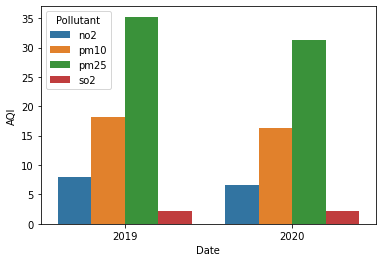

In [50]:
#Absolute amounts of each pollutant

years = year_country_pollut_df.sort_values(by='Pollutant').Date.dt.year
year_country_pollut = year_country_pollut_df.sort_values(by='Pollutant').AQI
hue = year_country_pollut_df.sort_values(by='Pollutant').Pollutant

sns.barplot(x=years, y=year_country_pollut, \
        alpha=1, hue=hue)

In the previous graph we can see that the pollutant values decrease in 2020, but how much exactly? Let's make a function to calculate it:

In [51]:
def year_t_conf_interval_pollutants(df_a, df_b, percent=True, unequal_var=True, alpha=0.95):
    '''Calculates the yearly relative change of the AQI for each pollutant for both input dataframes. The statistic is taken as df_a['AQI'] - df_b`['AQI'].
    INPUT: df_a, df_b: pd.Dataframe with the mean AQI values of the distributions we want to compare and the std_dev of those means
            percent: if True a percent with its corresponding error is returned. If False, only the returned value is the difference of the mean of both df_a and df_b
            unequal_var: if True a Welch's t-test is performed. If False population variances are assumed to be equal and thus a standard t-test is performed where the sample
            variance is the pooled variance
            alpha: represents the quantile to return in the confidence interval
    OUTPUT: pd.DataFrame with the pollutant and confidence interval of the AQI difference for that pollutant'''
    final_df = pd.DataFrame()
    
    for pollutant in df_a.Pollutant.unique():
        pollut_a = df_a[df_a.Pollutant == pollutant].AQI.values[0]
        pollut_b = df_b[df_b.Pollutant == pollutant].AQI.values[0]
        
        statistic = pollut_a - pollut_b
    
        std_a = df_a[df_a.Pollutant == pollutant].std_dev.values[0]
        std_b = df_b[df_b.Pollutant == pollutant].std_dev.values[0]
       
        
        n_a = df_a[df_a.Pollutant == pollutant]['No_points'].values[0]
        n_b = df_b[df_b.Pollutant == pollutant]['No_points'].values[0]
      

        
        if unequal_var:
            #Apply Welch t-test method
            std_statistic = np.sqrt(std_a**2 + std_b**2)
            # Welch's degrees of freedom
            degrees_freedom = (std_a**2+std_b**2)**2/(std_a**4/(n_a-1) + std_b**4/(n_b-1))

        else:
            # Apply standard method with pooled variance
            std_statistic = np.sqrt(((n_a - 1)*std_a**2 + (n_b - 1)*std_b**2)/(n_a + n_b - 2))
            degrees_freedom = n_a + n_b - 2
            

        # Calculate percentage with respect to the previous year
        if percent:
             # Calculate percentage with respect to the previous year
            ratio = statistic/pollut_b
            std_dev_ratio = ratio * np.sqrt((std_statistic / statistic)**2 + (std_b  / pollut_b)**2) # Propagation by Taylor approximation to first degree
           
            
            error_95th = stats.t.interval(df=degrees_freedom, alpha=alpha)[1] * std_dev_ratio

            percent = ratio *100
            std_95th_percent = error_95th*100

            CI = [percent, std_95th_percent]
        if not percent:
            # Calculate the difference between the mean of both years
            error = stats.t.interval(df=degrees_freedom, alpha=alpha)[1] * std_statistic
            CI = np.array([statistic, error])
        temp_df = pd.DataFrame({'Years_compared':str(df_a.Date.dt.year.unique()[0])+'-'+str(df_b.Date.dt.year.unique()[0]) , 'Pollutant': pollutant, \
                                    'middle': CI[0], 'std_dev': std_dev_ratio*100, 'std_95th': [CI[1]]})
        final_df = pd.concat([final_df, temp_df])
            
    return final_df.reset_index().drop('index', axis=1)

In [52]:
df_pollut_19 = year_country_pollut_df[year_country_pollut_df.Date.dt.year == 2019].sort_values(by='Pollutant')
df_pollut_20 = year_country_pollut_df[year_country_pollut_df.Date.dt.year == 2020].sort_values(by='Pollutant')

In [53]:
rel_pollut_19_20= year_t_conf_interval_pollutants(df_pollut_20, df_pollut_19, unequal_var=True)
rel_pollut_19_20

,Years_compared,Pollutant,middle,std_dev,std_95th
0,2020-2019,no2,-16.948848,-0.626402,-1.264158
1,2020-2019,pm10,-10.534637,-0.708450,-1.429005
2,2020-2019,pm25,-11.340578,-1.298409,-2.729322
3,2020-2019,so2,-5.548474,-0.584181,-1.177594


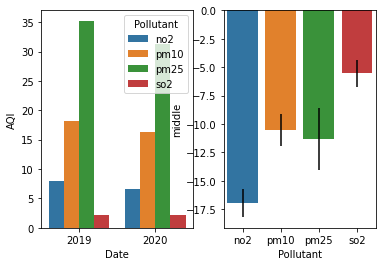

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2)

years = year_country_pollut_df.sort_values(by='Pollutant').Date.dt.year
year_country_pollut = year_country_pollut_df.sort_values(by='Pollutant').AQI
hue = year_country_pollut_df.sort_values(by='Pollutant').Pollutant

sns.barplot(x=years, y=year_country_pollut, \
        alpha=1, hue=hue, ax=ax[0])

x1 = rel_pollut_19_20.sort_values(by='Pollutant').Pollutant
y1 = rel_pollut_19_20.sort_values(by='Pollutant').middle
yerr1 = rel_pollut_19_20.sort_values(by='Pollutant').std_95th

sns.barplot(x=x1, y=y1, yerr=yerr1, ax=ax[1])

plt.show()


## How was the monthly evolution across the whole year of 2020 <a class='anchor' id='second_question'>

In order to do the monthly comparison between 2019 and 2020 we'll use the function below (month_t_conf_interval_pollutants()) 

In [65]:
def month_t_conf_interval_pollutants(df_a, df_b, percent=True, unequal_var=True, alpha=0.95):
    '''Calculates the yearly relative change of the AQI for each pollutant for both input dataframes. The statistic is taken as df_a.AQI - df_b.AQI.
    INPUT: df_a, df_b: pd.Dataframe with the mean AQI values of the distributions we want to compare and the std_dev of those means
            percent: if True a percent with its corresponding error is returned. If False, only the returned value is the difference of the mean of both df_a and df_b
            unequal_var: if True a Welch's t-test is performed. If False population variances are assumed to be equal and thus a standard t-test is performed where the sample
            variance is the pooled variance
            alpha: represents the quantile to return in the confidence interval
    OUTPUT: pd.DataFrame with the pollutant and confidence interval of the AQI difference for that pollutant'''
    final_df = pd.DataFrame()
    
    months = list(set(df_a.Date.dt.month.unique()).intersection(set(df_b.Date.dt.month.unique())))
    for month in months:
        for pollutant in df_a.Pollutant.unique():
            pollut_a = df_a[(df_a.Pollutant == pollutant) & (df_a.Date.dt.month == month)].AQI.values[0]
            pollut_b = df_b[(df_b.Pollutant == pollutant) & (df_b.Date.dt.month == month)].AQI.values[0]

            statistic = pollut_a - pollut_b

            std_a = df_a[df_a.Pollutant == pollutant].std_dev.values[0]
            std_b = df_b[df_b.Pollutant == pollutant].std_dev.values[0]
           

            n_a = df_a[df_a.Pollutant == pollutant]['No_points'].values[0]
            n_b = df_b[df_b.Pollutant == pollutant]['No_points'].values[0]
            


            if unequal_var:
                #Apply Welch t-test method
                std_statistic = np.sqrt(std_a**2 + std_b**2)
                # Welch's degrees of freedom
                degrees_freedom = (std_a**2+std_b**2)**2/(std_a**4/(n_a-1) + std_b**4/(n_b-1))

            else:
                # Apply standard method with pooled variance
                std_statistic = np.sqrt(((n_a - 1)*std_a**2 + (n_b - 1)*std_b**2)/(n_a + n_b - 2))
                degrees_freedom = n_a + n_b - 2


            if percent:
                 # Calculate percentage with respect to the previous year
                ratio = statistic/pollut_b
                std_dev_ratio = ratio * np.sqrt((std_statistic / statistic)**2 + (std_b  / pollut_b)**2) # Propagation by Taylor approximation to first degree
               

                error_95th = stats.t.interval(df=degrees_freedom, alpha=alpha)[1] * std_dev_ratio

                percent = ratio *100
                std_95th_percent = error_95th*100

                CI = [percent, std_95th_percent]
                
            if not percent:
                # Calculate the difference between the mean of both years
                error = stats.t.interval(df=degrees_freedom, alpha=alpha)[1] * std_statistic
                CI = np.array([statistic, error])
                
            temp_df = pd.DataFrame({'Years_compared':str(df_a.Date.dt.year.unique()[0])+'-'+str(df_b.Date.dt.year.unique()[0]) , 'Month': month, 'Pollutant': pollutant, \
                                        'middle': CI[0], 'std_dev': std_dev_ratio*100, 'std_95th': [CI[1]]})
            final_df = pd.concat([final_df, temp_df])
            
    return final_df.reset_index().drop('index', axis=1)

First we compute the monthly average of the pollutants in Spain:

In [56]:
month_country_pollut_df = monthly_country_pollutant(df_spain)

Beware: inserting the original DataFrame will imply a long runtime process (> 10 min). It is advised
                    to use the returned DataFrame after applying the monthly_city_pollutant() function. Do you want to continue anyway?

                    Type "y" for Yes

                    Type "n" for No
 y


Implementing function: monthly_city_pollutant. This may take a while.
Implementing function: monthly_country_pollutant


In [57]:
month_country_pollut_df


,Date,Month,Country,Country_name,No_points,Pollutant,AQI,std_dev,conf_interval_95%
0,2019-01-01,1,ES,Spain,10,pm25,36.137820,0.949186,2.147207
1,2019-01-01,1,ES,Spain,21,no2,11.124989,0.191468,0.399396
2,2019-01-01,1,ES,Spain,21,pm10,17.291600,0.319628,0.666732
3,2019-01-01,1,ES,Spain,21,so2,2.434591,0.032127,0.067017
4,2019-02-01,2,ES,Spain,10,pm25,51.928571,1.240456,2.806107
...,...,...,...,...,...,...,...,...,...
91,2020-11-01,11,ES,Spain,23,so2,2.006626,0.041144,0.085327
92,2020-12-01,12,ES,Spain,13,pm25,23.804581,0.850773,1.853676
93,2020-12-01,12,ES,Spain,23,no2,7.397500,0.135497,0.281004
94,2020-12-01,12,ES,Spain,23,pm10,11.987642,0.335869,0.696550


And we apply now the month_t_conf_interval_pollutants() function:

In [58]:
# Inputs for the function
df_month_pollut_19 = month_country_pollut_df[month_country_pollut_df.Date.dt.year == 2019].sort_values(by='Pollutant')
df_month_pollut_20 = month_country_pollut_df[month_country_pollut_df.Date.dt.year == 2020].sort_values(by='Pollutant')

rel_pollut_month_19_20 = month_t_conf_interval_pollutants(df_month_pollut_20, df_month_pollut_19, unequal_var=True)
rel_pollut_month_19_20.head(50)

,Years_compared,Month,Pollutant,middle,std_dev,std_95th
0,2020-2019,1,no2,-1.808100,-1.468606,-2.960603
1,2020-2019,1,pm10,12.869689,1.706221,3.441784
2,2020-2019,1,pm25,10.398382,2.486503,5.185881
3,2020-2019,1,so2,-5.855445,-1.364939,-2.750904
4,2020-2019,2,no2,-17.717722,-1.346046,-2.713530
5,2020-2019,2,pm10,-12.134631,-1.091259,-2.201283
6,2020-2019,2,pm25,-16.335024,-1.738690,-3.626232
7,2020-2019,2,so2,-10.349830,-1.382420,-2.786134
8,2020-2019,3,no2,-34.590421,-1.907721,-3.845826
9,2020-2019,3,pm10,-23.071911,-1.445198,-2.915250


<AxesSubplot:xlabel='Month', ylabel='middle'>

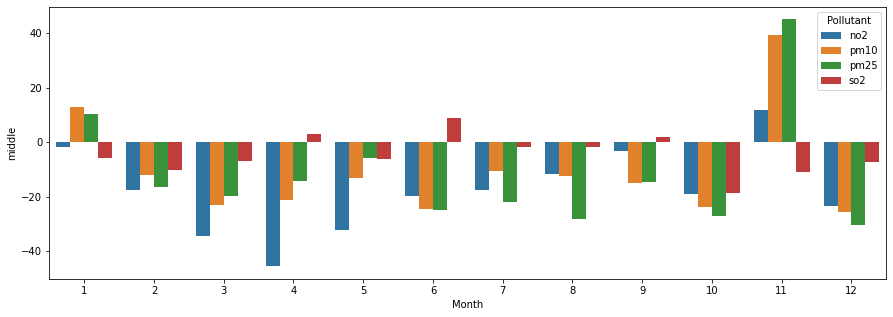

In [59]:
months = rel_pollut_month_19_20.sort_values(by='Month').Month
percent_difference = rel_pollut_month_19_20.sort_values(by='Month')['middle']
hue = rel_pollut_month_19_20.sort_values(by='Month').Pollutant

plt.rcParams["figure.figsize"] = (15,5)
sns.barplot(x=months, y=percent_difference, \
        alpha=1, hue=hue)

<AxesSubplot:xlabel='Month', ylabel='AQI'>

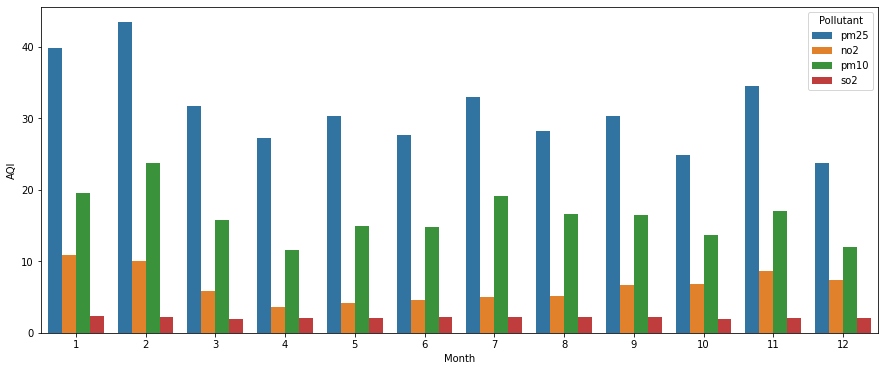

In [62]:
months = month_country_pollut_df[month_country_pollut_df.Date.dt.year == 2020].sort_values(by=['Month']).Month
abs_val = month_country_pollut_df[month_country_pollut_df.Date.dt.year == 2020].sort_values(by=['Month'])['AQI']
hue = month_country_pollut_df[month_country_pollut_df.Date.dt.year == 2020].sort_values(by=['Month']).Pollutant

plt.rcParams["figure.figsize"] = (15,6)
sns.barplot(x=months, y=abs_val, \
        alpha=1, hue=hue)

In [60]:
def plot_with_err(x, data, **kwargs):
    y = data.middle
    lines = plt.plot(x, y, '-', marker='o', **kwargs)
    middle = data.middle
    std = data.std_95th
    plt.fill_between(x, middle - std, middle + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)


(0.0, 12.0)

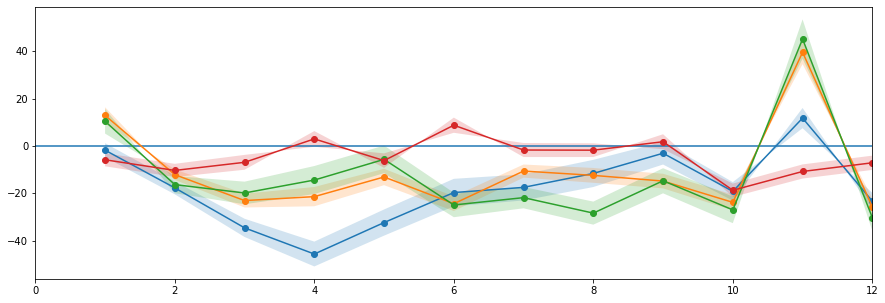

In [61]:
for pollutant in rel_pollut_month_19_20.Pollutant.unique():
    
    plot_with_err(x=rel_pollut_month_19_20[rel_pollut_month_19_20.Pollutant == pollutant].Month, data=rel_pollut_month_19_20[rel_pollut_month_19_20.Pollutant == pollutant])

plt.hlines(y=0, xmin=0, xmax=12)
plt.xlim(0, 12)

NO$_2$ is the pollutant that decreases the most during the confinement since it is the main combustion byproduct from vehicles. To visualize better its absolute levels and trend let's plot the 2019 and 2020 side-by-side:

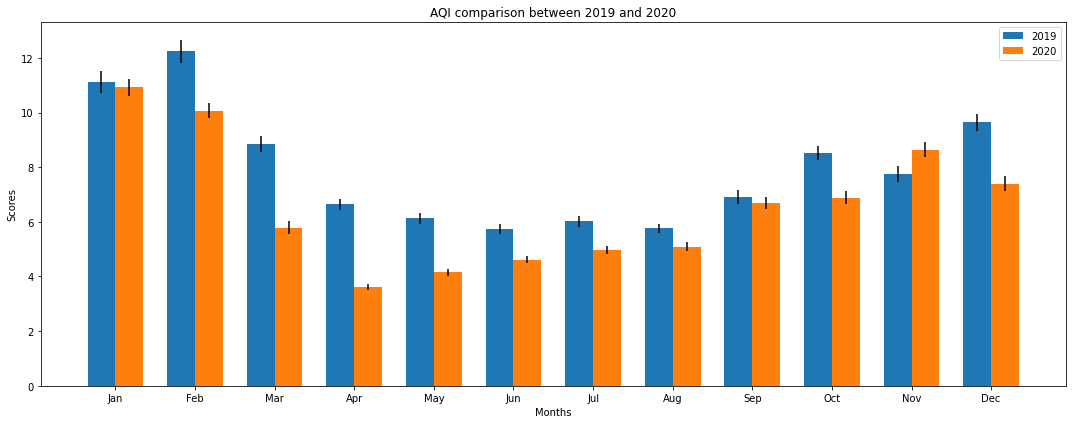

In [73]:
# Graphs a bar plot with 2019-2020 absolute values of NO2 AQI.

year_19 =  df_month_pollut_19[df_month_pollut_19.Pollutant == 'no2'].sort_values(by='Month').AQI
year_20 =  df_month_pollut_20[df_month_pollut_20.Pollutant == 'no2'].sort_values(by='Month').AQI

err_19 = df_month_pollut_19[df_month_pollut_19.Pollutant == 'no2'].sort_values(by='Month')['conf_interval_95%']
err_20 = df_month_pollut_20[df_month_pollut_20.Pollutant == 'no2'].sort_values(by='Month')['conf_interval_95%']

labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, year_19, width, label='2019', yerr= err_19)
rects2 = ax.bar(x + width/2, year_20, width, label='2020', yerr= err_20)


ax.set_ylabel('Scores')
ax.set_xlabel('Months')
ax.set_title('AQI comparison between 2019 and 2020')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

## How did the air quality changed in the Spanish cities? <a class='anchor' id='third_question'>

Since NO$_2$ is the main pollutant generated by cars, we will be looking at this pollutant's variation in 2020 relative to 2019. In order to do this calculation we will use the function below (year_t_conf_interval_city_pollutant()):

In [74]:
def year_t_conf_interval_city_pollutant(df_a, df_b, percent=True, unequal_var=True, alpha=0.95):
    '''Calculates the yearly relative change of the overall AQI for each city in every country present in both input dataframes. The statistic is taken as AQI(df_a) - AQI(df_b).
    INPUT: df_a, df_b: pd.Dataframe with the yearly mean AQI values of the cities we want to compare and the std_dev of those means
            percent: if True a percent with its corresponding error is returned. If False, only the returned value is the difference of the mean of both df_a and df_b
            unequal_var: if True a Welch's t-test is performed. If False population variances are assumed to be equal and thus a standard t-test is performed where the sample
            variance is the pooled variance
            alpha: represents the quantile to return in the confidence interval
    OUTPUT: pd.DataFrame with the confidence interval of the yearly AQI difference'''
    final_df = pd.DataFrame()
    
    #Find the common countries for both dataframes 
    countries = list(set(df_a.Country.unique()).intersection(set(df_b.Country.unique())))
    for country in countries:
        country_filter_a = df_a.Country == country
        country_filter_b = df_b.Country == country
        
        #Find the common pollutants for both dataframes
        pollutants = list(set(df_a[country_filter_a].Pollutant.unique()).intersection(set(df_b[country_filter_b].Pollutant.unique())))
        for pollutant in pollutants:
            pollutant_filter_a = df_a.Pollutant == pollutant
            pollutant_filter_b = df_b.Pollutant == pollutant
            
        
        #Find the common cities for both input dataframes
            cities = list(set(df_a[country_filter_a & pollutant_filter_a].City.unique()).intersection(set(df_b[country_filter_b & pollutant_filter_b].City.unique())))
            for city in cities:
                city_filter_a = df_a.City == city
                city_filter_b = df_b.City == city

                mean_a = df_a[city_filter_a & country_filter_a & pollutant_filter_a].AQI.values[0]
                mean_b = df_b[city_filter_b & country_filter_b & pollutant_filter_b].AQI.values[0]

                std_a = df_a[city_filter_a & country_filter_a & pollutant_filter_a].std_dev.values[0]
                std_b = df_b[city_filter_b & country_filter_b & pollutant_filter_b].std_dev.values[0]

                statistic = mean_a-mean_b

                n_a = df_a[city_filter_a & country_filter_a & pollutant_filter_a]['No_points'].values[0]
                n_b = df_b[city_filter_b & country_filter_b & pollutant_filter_b]['No_points'].values[0]

                if unequal_var:
                    #Apply Welch t-test method
                    std_statistic = np.sqrt(std_a**2 + std_b**2)
                    # Welch's degrees of freedom
                    degrees_freedom = (std_a**2+std_b**2)**2/(std_a**4/(n_a-1) + std_b**4/(n_b-1))

                else:
                    # Apply standard method with pooled variance
                    std_statistic = np.sqrt(((n_a - 1)*std_a**2 + (n_b - 1)*std_b**2)/(n_a + n_b - 2))
                    degrees_freedom = n_a + n_b - 2

                #Calculate percentage with respect to the previous year
                if percent:
                    ratio = statistic/mean_b

                    std_dev_mean_b = std_b
                    std_dev_ratio = ratio * np.sqrt((std_statistic / statistic)**2 + (std_dev_mean_b  / mean_b)**2) # Propagation by Taylor approximation to first degree



                    error_95th = stats.t.interval(df=degrees_freedom, alpha=alpha)[1] * std_dev_ratio

                    percent = ratio *100
                    std_95th_percent = error_95th*100

                    CI = [percent, std_95th_percent]
                if not percent:
                    error = stats.t.interval(df=degrees_freedom, alpha=alpha)[1] * std_statistic
                    CI = np.array([statistic, error])

                temp_df = pd.DataFrame({'Year':str(df_a.Date.dt.year.unique()[0])+'-'+str(df_b.Date.dt.year.unique()[0]) , 'Country': country, 'City': city, 'Pollutant': pollutant, \
                                                'rel_value': CI[0], 'std': std_dev_ratio*100, 'std_95th(%)': [CI[1]]})
                final_df = pd.concat([final_df, temp_df])
            
    return final_df.reset_index().drop('index', axis=1)

In [75]:
year_city_pollut_df = yearly_city_pollutant(df_spain)

Beware: inserting the original DataFrame will imply a long runtime process (> 10 min). It is advised
                    to use the returned DataFrame after applying the monthly_city_pollutant() function. Do you want to continue anyway?

                    Type "y" for Yes

                    Type "n" for No
 y


Implementing function: monthly_city_pollutant. This may take a while.
Implementing function: yearly_city_pollutant


In [76]:
df_19 = year_city_pollut_df[(year_city_pollut_df.Date.dt.year == 2019)]
df_20 = year_city_pollut_df[(year_city_pollut_df.Date.dt.year == 2020)]

comp_year_city_pollut_df = year_t_conf_interval_city_pollutant(df_20, df_19, unequal_var=False, percent=True)

In [86]:
comp_year_city_pollut_df.head()

,Year,Country,City,Pollutant,rel_value,std,std_95th(%)
0,2020-2019,ES,Pamplona,pm10,-11.638912,-2.252418,-4.684160
1,2020-2019,ES,Córdoba,pm10,-7.849031,-1.966140,-4.077525
2,2020-2019,ES,Santander,pm10,-8.049071,-1.667243,-3.457650
3,2020-2019,ES,Sevilla,pm10,-16.034220,-1.667819,-3.458844
4,2020-2019,ES,Zaragoza,pm10,1.521472,3.138051,6.652370


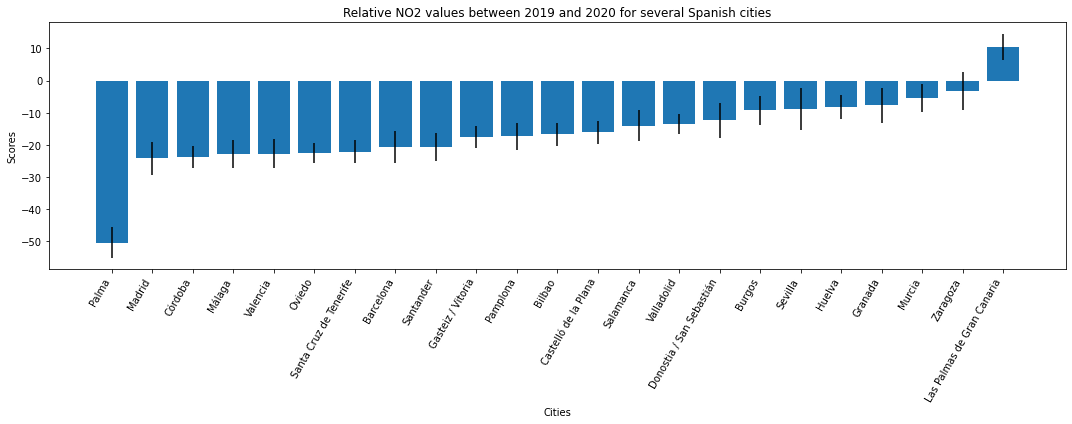

In [78]:
sorted_df = comp_year_city_pollut_df.sort_values(by='rel_value')

pollut_no2 =  sorted_df[(sorted_df.Pollutant == 'no2')].rel_value
err_no2 = sorted_df[(sorted_df.Pollutant == 'no2')]['std_95th(%)']

labels = sorted_df.City.unique()

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x, pollut_no2, label='no2', yerr=err_no2)

ax.set_ylabel('Scores')
ax.set_xlabel('Cities')
ax.set_title('Relative NO2 values between 2019 and 2020 for several Spanish cities')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=60, ha='right')


fig.tight_layout()

plt.show()